# Install and import related modules

In [ ]:
!pip install matplotlib==3.3.1

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Read images

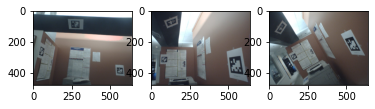

In [ ]:
img1 = cv2.imread('00003.jpg')
img2 = cv2.imread('00006.jpg')
img3 = cv2.imread('00007.jpg')
fig, axes = plt.subplots(1, 3)
axes[0].imshow(img1[:, :, ::-1])
axes[1].imshow(img2[:, :, ::-1])
axes[2].imshow(img3[:, :, ::-1])

#Input the pre-calibrated intrinsic parameters

In [ ]:
fx = 520.544057821402
fy = 520.1849733954289
cx = 291.4731915436965
cy = 239.5481569250349
k1 = -0.09121325191796478
k2 = 0.1657800009678882
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
distCoeffs = np.array([k1, k2, 0, 0])

#Detect AprilTag corners

id1: [8 5 4]
id2: [5 8]
id3: [8 7]


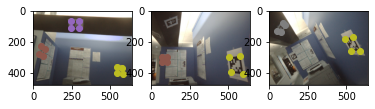

In [ ]:
arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_APRILTAG_36h11)
arucoParams = cv2.aruco.DetectorParameters_create()
impts1, ids1, _ = cv2.aruco.detectMarkers(img1, arucoDict, parameters=arucoParams)
impts2, ids2, _ = cv2.aruco.detectMarkers(img2, arucoDict, parameters=arucoParams)
impts3, ids3, _ = cv2.aruco.detectMarkers(img3, arucoDict, parameters=arucoParams)

ids1 = ids1.ravel()
ids2 = ids2.ravel()
ids3 = ids3.ravel()

print("id1:", ids1)
print("id2:", ids2)
print("id3:", ids3)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(img1, cmap='gray')
axes[1].imshow(img2, cmap='gray')
axes[2].imshow(img3, cmap='gray')

for idx, pts in zip(ids1, impts1):
  axes[0].scatter(pts[0, :, 0], pts[0, :, 1], color='C%d' % idx)

for idx, pts in zip(ids2, impts2):
  axes[1].scatter(pts[0, :, 0], pts[0, :, 1], color='C%d' % idx)

for idx, pts in zip(ids3, impts3):
  axes[2].scatter(pts[0, :, 0], pts[0, :, 1], color='C%d' % idx)

# Inital pose estimation for img1 and img2

## Estimate essential matrix

In [ ]:
x1 = np.concatenate((impts1[1][0], impts1[0][0]))
x2 = np.concatenate((impts2[0][0], impts2[1][0]))
E, mask = cv2.findEssentialMat(x1, x2, K)

## Decompose essential matrix

In [ ]:
RR1, RR2, t = cv2.decomposeEssentialMat(E)
projMatLeft = K @ np.concatenate((np.eye(3), np.zeros((3, 1))), axis=1)
projMatRight1 = K @ np.concatenate((RR1, t), axis=1)
projMatRight2 = K @ np.concatenate((RR1, -t), axis=1)
projMatRight3 = K @ np.concatenate((RR2, t), axis=1)
projMatRight4 = K @ np.concatenate((RR2, -t), axis=1)

## Triangulate points

In [ ]:
X1 = cv2.triangulatePoints(projMatLeft, projMatRight1, x1.T, x2.T)
X2 = cv2.triangulatePoints(projMatLeft, projMatRight2, x1.T, x2.T)
X3 = cv2.triangulatePoints(projMatLeft, projMatRight3, x1.T, x2.T)
X4 = cv2.triangulatePoints(projMatLeft, projMatRight4, x1.T, x2.T)

X1 = X1 / X1[-1]
X2 = X2 / X2[-1]
X3 = X3 / X3[-1]
X4 = X4 / X4[-1]

print('z1:', X1[2])
print('z2:', X2[2])
print('z3:', X3[2])
print('z4:', X4[2])

z1: [ 1.3016268   1.0048659   1.0383105   1.3483775  -0.88343203 -0.9715261
 -0.9835666  -0.8970174 ]
z2: [-1.3016268  -1.0048659  -1.0383105  -1.3483775   0.88343203  0.9715261
  0.9835666   0.8970174 ]
z3: [-0.6608768  -0.6023162  -0.61811393 -0.67702377 -0.88354874 -0.88772327
 -0.9053299  -0.9001678 ]
z4: [0.6608768  0.6023162  0.61811393 0.67702377 0.88354874 0.88772327
 0.9053299  0.9001678 ]


Values in z4 are all positive. Therefore, we choose (RR2, -t) as the intial pose for img2, and X4 as the intial position for the object points.

#Initial pose estimation for img3

In [ ]:
x3 = impts3[0][0] #4x2
X4 = X4.T
ret, rvec, tvec = cv2.solvePnP(X4[4:, :3], x3, K, distCoeffs)

# Bundle Adjustment

## Create inital parameter vector

In [ ]:
# params0 = [rvec1, rvec2, rvec3, tvec1, tvec2, tvec3, X1, X2, X3, X4, X5, X6, X7, X8]
rvec1 = cv2.Rodrigues(np.eye(3))[0][:, 0] #3
rvec2 = cv2.Rodrigues(RR2)[0][:, 0]  #3
rvec3 = rvec[:, 0] #3


tvec1 = np.zeros(3) #3
tvec2 = -t[:, 0] #3
tvec3 = tvec[:, 0] #3

X_0 = X4[:, :3].ravel() #24


params0 = np.concatenate([rvec1, rvec2, rvec3, tvec1, tvec2, tvec3, X_0]) 

## Create visibility matrix and observations

Visibility matrix signifies the relationship between the camera and a point. $V_{ij}$ is one if $j$ th point is visible from the $i$ th camera and zero otherwise.

In [ ]:
visibility = []

for i in range(3):
  if i < 2:
    visibility.append([True]*8)
  else:
    visibility.append([False]*4 + [True]*4)

visibility = np.array(visibility, dtype=bool)
x_obs = np.concatenate([x1, x2, impts3[0][0]]) # Nx20
print(visibility)

[[ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [False False False False  True  True  True  True]]


## Create objective function

(-4.0, 4.0)

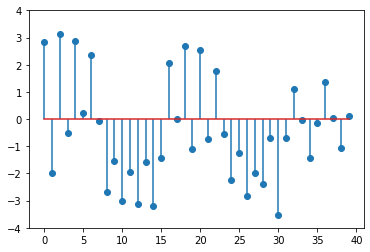

In [ ]:
def fun(params, K, distCoeffs, n_cams, visibility, x_obs):
    rvecs = params[:3*n_cams]
    tvecs = params[3*n_cams:6*n_cams]
    X = params[6*n_cams:] 
    x_hat = []
    for i in range(n_cams):
        rvec, tvec = rvecs[i*3:i*3+3], tvecs[i*3:i*3+3]
        mask = visibility[i]
        x = cv2.projectPoints(X.reshape(-1, 3), rvec, tvec, K, distCoeffs)[0][mask, 0, :] #N_ix2
        x_hat.append(x)
    x_hat = np.concatenate(x_hat) 
    return (x_hat - x_obs).ravel()    

plt.stem(fun(params0, K, distCoeffs, 3, visibility, x_obs))
plt.ylim([-4, 4])

## Optimization

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.5159e+01                                    1.40e+04    
       1              5         2.8572e+00      7.23e+01       7.20e-02       3.17e+03    
       2              7         1.2537e+00      1.60e+00       2.74e-02       4.43e+02    
       3              9         1.2347e+00      1.90e-02       1.57e-02       1.13e+02    
       4             11         1.2333e+00      1.38e-03       7.50e-03       8.15e+00    
       5             13         1.2333e+00      8.26e-06       4.00e-03       2.39e+00    
`ftol` termination condition is satisfied.
Function evaluations 13, initial cost 7.5159e+01, final cost 1.2333e+00, first-order optimality 2.39e+00.


(-4.0, 4.0)

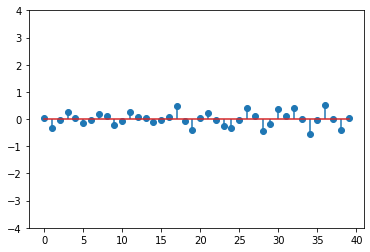

In [ ]:
res = least_squares(fun, params0, verbose=2, x_scale='jac', ftol=1e-4, method='trf', args=(K, distCoeffs, 3, visibility, x_obs))
rvec1_o, rvec2_o, rvec3_o = res.x[:3], res.x[3:6], res.x[6:9]
tvec1_o, tvec2_o, tvec3_o = res.x[9:12], res.x[12:15], res.x[15:18]
X_o = res.x[18:].reshape(-1, 3)
plt.stem(res.fun)
plt.ylim([-4, 4])

#Visualization

[0.06164717 0.06153202 0.06227978]


Text(0.5, 0, 'Z')

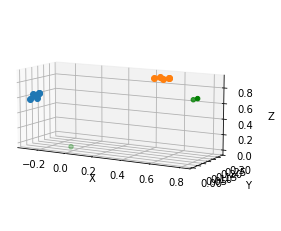

In [ ]:
R1_o, R2_o, R3_o = cv2.Rodrigues(rvec1_o[:, None])[0], cv2.Rodrigues(rvec2_o[:, None])[0], cv2.Rodrigues(rvec3_o[:, None])[0]
p1, p2, p3 = -R1_o.T @ tvec1_o, -R2_o.T @ tvec2_o, -R3_o.T @ tvec3_o

fig = plt.figure()


ax = fig.add_subplot(projection='3d')
ax.set_box_aspect((np.ptp(X_o[:, 0]), np.ptp(X_o[:, 1]), np.ptp(X_o[:, 2])))

# plot optimized camera pose and markers
ax.plot(X_o[[0, 1, 2, 3, 0], 0], X_o[[0, 1, 2, 3, 0], 1], X_o[[0, 1, 2, 3, 0], 2], marker='o', color='C0')
ax.plot(X_o[[4, 5, 6, 7, 4], 0], X_o[[4, 5, 6, 7, 4], 1], X_o[[4, 5, 6, 7, 4], 2], marker='o', color='C1')
ax.scatter([p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]], [p1[2], p2[2], p3[2]], marker='o', color='g')


# plot inital camera pose and markers
# R1_0, R2_0, R3_0 = cv2.Rodrigues(rvec1[:, None])[0], cv2.Rodrigues(rvec2[:, None])[0], cv2.Rodrigues(rvec3[:, None])[0]
# p1_0, p2_0, p3_0 = -R1_0.T @ tvec1, -R2_0.T @ tvec2, -R3_0.T @ tvec3


# X_0 = X_0.reshape(-1, 3)
# ax.plot(X_0[[0, 1, 2, 3, 0], 0], X_0[[0, 1, 2, 3, 0], 1], X_0[[0, 1, 2, 3, 0], 2], marker='o', color='C4')
# ax.plot(X_0[[4, 5, 6, 7, 4], 0], X_0[[4, 5, 6, 7, 4], 1], X_0[[4, 5, 6, 7, 4], 2], marker='o', color='C5')
# ax.scatter([p1_0[0], p2_0[0], p3_0[0]], [p1_0[1], p2_0[1], p3_0[1]], [p1_0[2], p2_0[2], p3_0[2]], marker='o', color='r')

ax.azim = -60
ax.elev = 10
print(np.linalg.norm(X_o[1:4] - X_o[0:3], axis=-1))


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

#Homework

Triangulate the top-right corner of the right poster using the optimized camera pose:

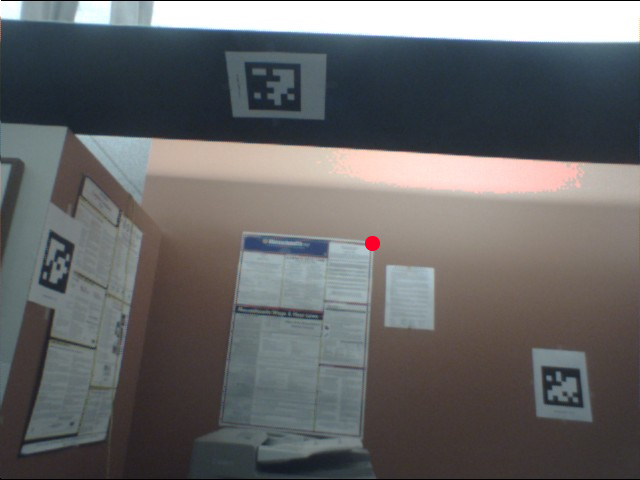


##Measure image cooridnates

Hint: You may use Windows Paint to measure the image cooridnates.

In [ ]:
# Hint: Image coordinates should be stored in an 1x2 numpy array:
x_left =  
x_right =

## Create projection matrix

In [ ]:
# Hint: P = K @ np.concatenate((R, t), axis=1). 
# You need to use the optimized R and t (R1_o, R2_o, R3_o, tvec1_o, tvec2_o, tvec3_o) after the bundle adjustment
P_left = 
P_right = 

##Triangulate point

In [ ]:
# Hint: Use cv2.triangulatePoints(). Pay attnention to the I/O array dimensions. Normalize the final homogenous coordinates.
# reference https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#gad3fc9a0c82b08df034234979960b778c
X_corner = 
print(X_corner)